###AI In Industry Project
####team members:
#####Parsa Mastouri Kashani
#####Freddy Fernandes
#####Arina Sadeghi Khiabanian

In [1]:
!nvidia-smi

Tue Mar 19 16:16:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!gdown https://www.timeseriesclassification.com/aeon-toolkit/ECG5000.zip

Downloading...
From: https://www.timeseriesclassification.com/aeon-toolkit/ECG5000.zip
To: /content/ECG5000.zip
100% 10.6M/10.6M [00:01<00:00, 7.83MB/s]


In [3]:
!unzip ECG5000.zip

Archive:  ECG5000.zip
  inflating: ECG5000.txt             
  inflating: ECG5000_TEST.arff       
  inflating: ECG5000_TEST.txt        
  inflating: ECG5000_TRAIN.arff      
  inflating: ECG5000_TRAIN.txt       
  inflating: ECG5000_TEST.ts         
  inflating: ECG5000_TRAIN.ts        


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
import os

## 1. Data Loading and Preprocessing

In [5]:
from scipy.io.arff import loadarff
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import time
import copy
import shutil
import seaborn as sns
import numpy as np
import torch
import pandas as pd

from torch import nn, optim


from matplotlib import pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [6]:
%matplotlib inline
%config InlineBackend.figure_format="retina"

# New color palette and styling
sns.set(style="darkgrid", palette="deep", font_scale=1.1)

# Adjusted figure size
plt.rcParams["figure.figsize"] = 10, 6

# Random seed initialization
RANDOM_SEED = 134
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
EPOCHS=107

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is {device}")

The device is cuda


In [7]:
with open("ECG5000_TRAIN.arff") as f:
  data, _ = loadarff(f)
  train = pd.DataFrame(data)

with open("ECG5000_TEST.arff") as f:
  data, _ = loadarff(f)
  test = pd.DataFrame(data)

In [8]:
df =train.append(test)
df=df.sample(frac=1.0)

<ipython-input-8-13b449d30a65>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df =train.append(test)


In [9]:
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
534,-0.842621,-1.780452,-3.776014,-4.896760,-4.353167,-3.453653,-2.260882,-1.555755,-0.882176,-0.046324,...,-0.635926,-0.341456,0.481320,1.002268,1.465191,1.644362,0.393905,0.299489,-0.130813,b'1'
250,-1.576042,-3.337933,-3.887331,-4.626069,-4.214526,-3.192969,-1.841315,-1.439540,-1.083829,-0.329456,...,1.638520,1.009642,0.223338,-0.735181,-1.758531,-2.064131,-1.918372,-1.099610,-1.036411,b'1'
2078,1.454819,0.165713,-2.042767,-3.386685,-4.213379,-4.476887,-3.355232,-2.036891,-1.776199,-0.987669,...,0.398513,1.128957,1.248494,1.760980,1.629917,1.535541,0.683245,0.403350,0.761785,b'1'
3025,0.677061,-0.668202,-1.479478,-1.967005,-1.967303,-2.007898,-2.109426,-2.287696,-1.825278,-1.433943,...,-1.406049,-1.966325,-2.412170,-3.319095,-3.953773,-4.594259,-3.487196,-3.183921,-1.498599,b'2'
3033,0.467185,0.101645,-0.162644,-0.486482,-0.582705,-0.454435,-0.223405,-0.041010,0.061389,0.193382,...,-2.620202,-2.641405,-2.628147,-2.540519,-2.470406,-2.564406,-2.747627,-2.480586,-2.358128,b'3'


In [10]:
df["target"].unique()

array([b'1', b'2', b'3', b'4', b'5'], dtype=object)

In [11]:
len(df['att140'].unique())

5000

In [12]:
class_names =['Normal','PVC', 'R on T','SP','UB']
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

df['target'] = df['target'].str.decode('utf-8')

df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

<ipython-input-13-3a935097de98>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_names)


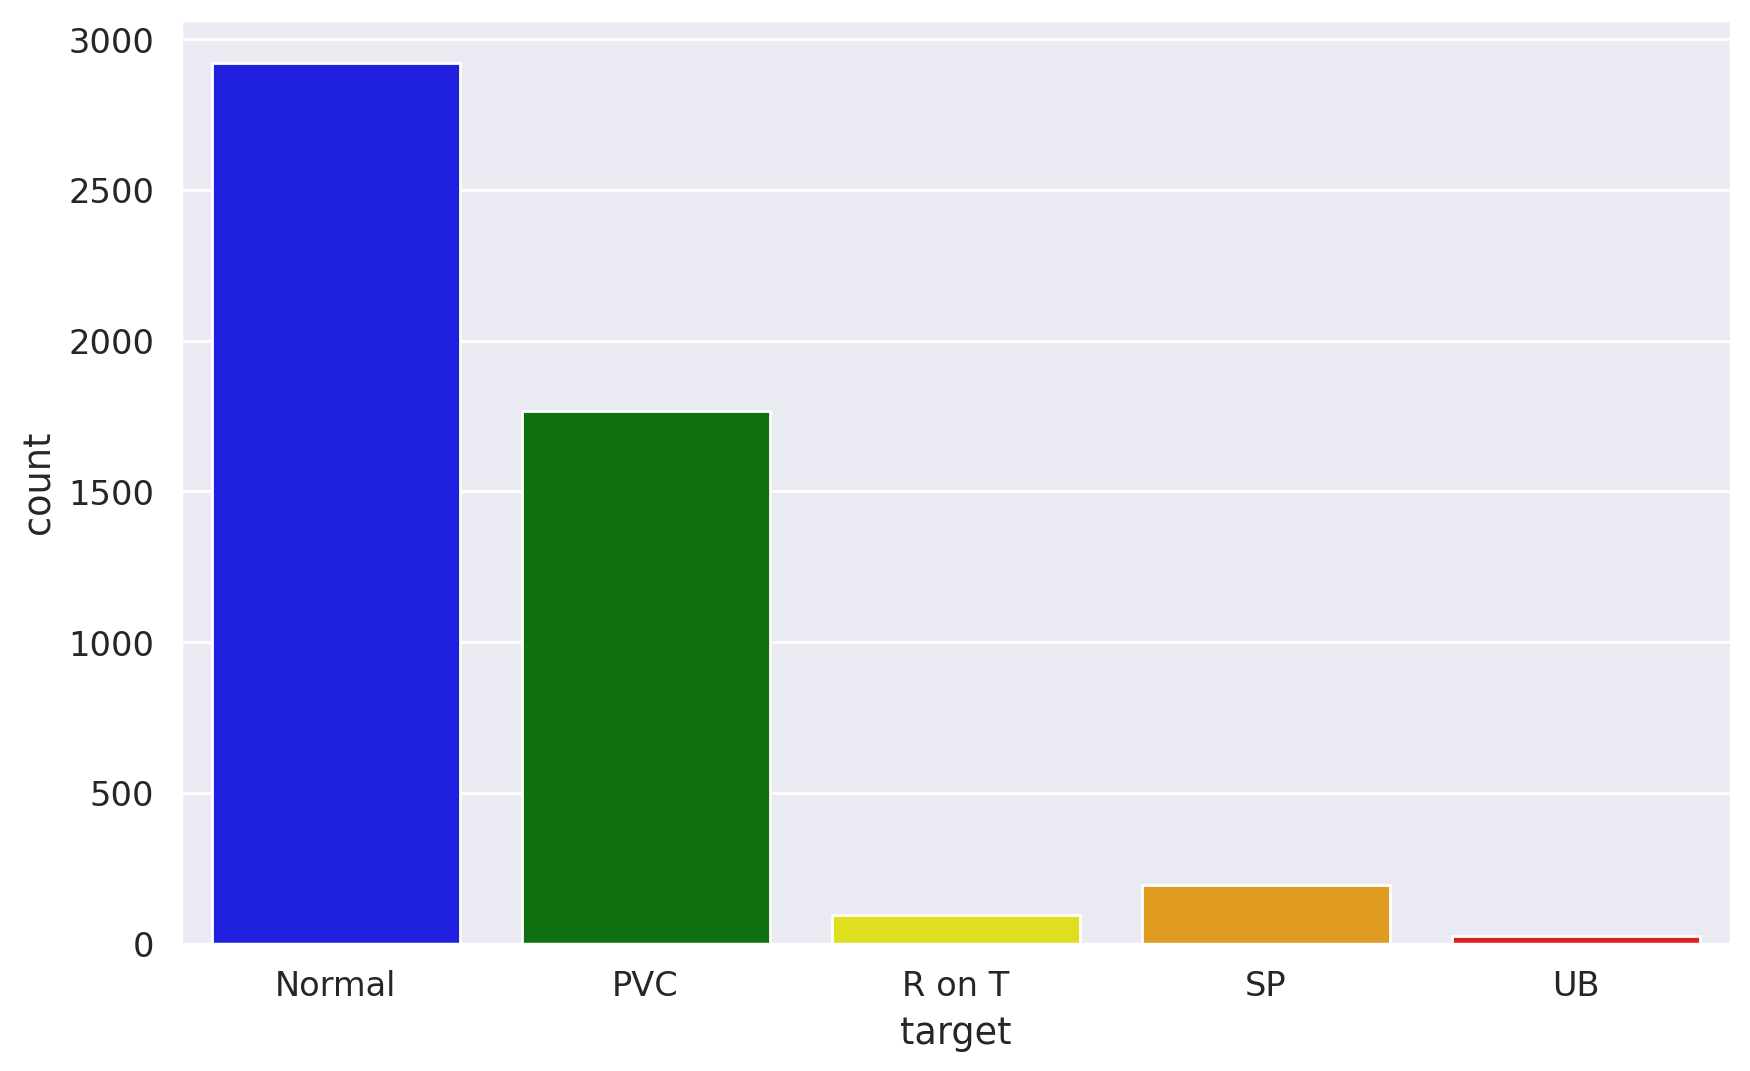

In [13]:
# Define a color palette for each class
color_palette = ['blue', 'green', 'yellow', 'orange', 'red']

# Plot the countplot with the specified order and palette
ax = sns.countplot(data=df, x='target', palette=color_palette, hue='target', legend=False)
ax.set_xticklabels(class_names)

plt.show()

In [14]:
# concatenate training and test data to a single dataframe
column_names = list(df.columns)

In [15]:
column_names[-1] = "label"
df.columns = column_names
df["label"] = df["label"].astype('int32')

# Shuffling the rows in the dataframe to mix test and training data
df.sample(frac=1)

df.head(3)

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,label
534,-0.842621,-1.780452,-3.776014,-4.896760,-4.353167,-3.453653,-2.260882,-1.555755,-0.882176,-0.046324,...,-0.635926,-0.341456,0.481320,1.002268,1.465191,1.644362,0.393905,0.299489,-0.130813,1
250,-1.576042,-3.337933,-3.887331,-4.626069,-4.214526,-3.192969,-1.841315,-1.439540,-1.083829,-0.329456,...,1.638520,1.009642,0.223338,-0.735181,-1.758531,-2.064131,-1.918372,-1.099610,-1.036411,1
2078,1.454819,0.165713,-2.042767,-3.386685,-4.213379,-4.476887,-3.355232,-2.036891,-1.776199,-0.987669,...,0.398513,1.128957,1.248494,1.760980,1.629917,1.535541,0.683245,0.403350,0.761785,1


In [16]:
# unique label counts
print(df["label"].value_counts())
unique_labels = df["label"].unique()

1    2919
2    1767
4     194
3      96
5      24
Name: label, dtype: int64


It appears that the dataset comprises 2919 instances classified as normal samples, alongside 1767 instances labeled as anomaly samples belonging to various subcategories, including 194 labeled 'PVC', 96 labeled 'R on T', and 24 labeled 'SP'.

Code to plot just one example:

In [17]:
def plot_time_series_sample(data_df, loc, color):
    tmp_df = data_df.copy()
    tmp_df = tmp_df.drop(columns=["label"])
    tmp_df = tmp_df.iloc[loc].transpose()
    tmp_df = tmp_df.reset_index()

    column_names = list(tmp_df.columns)
    column_names[-1] = "y"
    column_names[0] = "x"
    tmp_df.columns = column_names
    fig, ax = plt.subplots(figsize=(5, 3))
    sns.lineplot(data=tmp_df, x="x",y="y", ax=ax, color=color)
    fig.tight_layout()
    plt.title("ECG of a heartbeat", fontsize=14)
    ax.set_ylabel("voltage (amplitude)")
    ax.set_xlabel("timesteps")
    # Remove x-axis tick labels
    ax.set_xticklabels([])

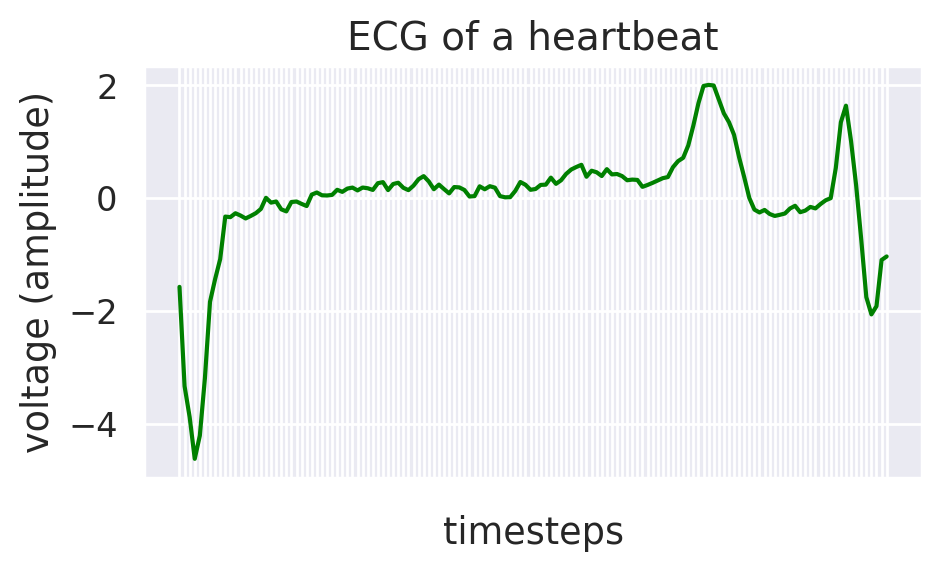

In [18]:
plot_time_series_sample(df, 1, "green")

In [19]:
def plot_time_series(label, data_df, ax, color):
    tmp_df = data_df.copy()
    tmp_df = tmp_df[tmp_df["label"] == label]
    tmp_df = tmp_df.drop(columns=["label"])
    tmp_df = tmp_df.transpose()
    tmp_df['std'] = tmp_df.std(axis=1)
    tmp_df['mean'] = tmp_df.mean(axis=1)
    tmp_df['ci_lower'] = tmp_df['mean'] - tmp_df['std']
    tmp_df['ci_upper'] = tmp_df['mean'] + tmp_df['std']
    tmp_df = tmp_df.reset_index()
    sns.lineplot(data=tmp_df, x="index",y="mean", ax=ax, color=color)
    ax.fill_between(tmp_df['index'], tmp_df['ci_lower'], tmp_df['ci_upper'], color=color, alpha=.15)

    class_dict = dict({1: "Normal", 2: "PVC", 3: "R on T", 4: "SP", 5: "UB"})
    ax.set_title("Label: {}".format(class_dict[label]))
    ax.set_ylabel("voltage (amplitude)")
    ax.set_xlabel("timesteps")
    # Remove x-axis tick labels
    ax.set_xticklabels([])

Text(0.5, 1.02, 'ECG analysis of normal and anomalous heartbeats')

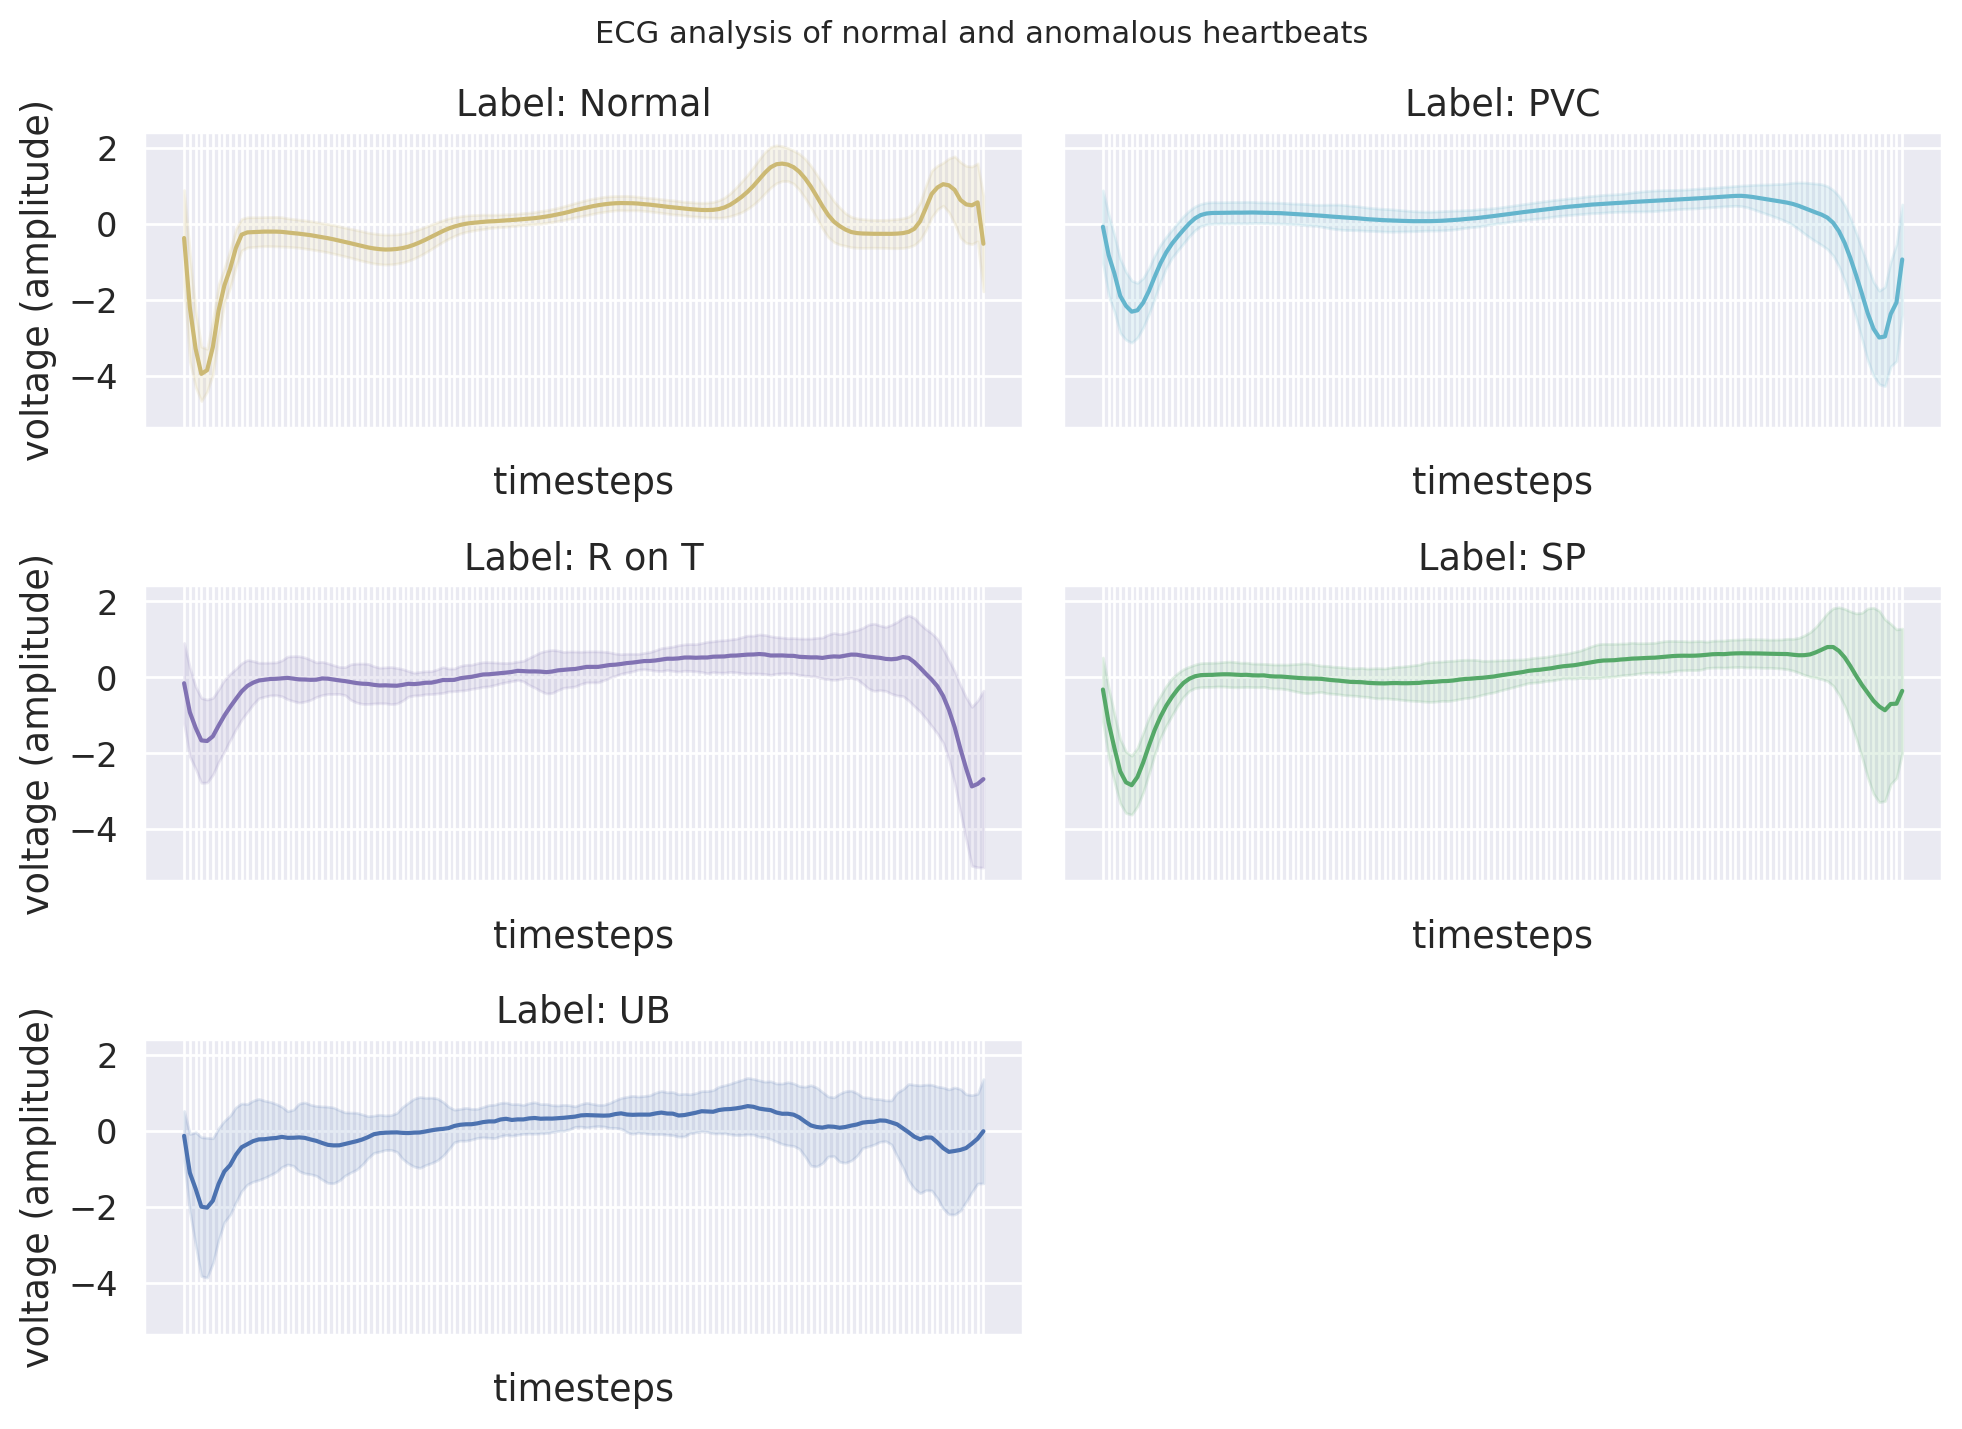

In [20]:
fig, axes = plt.subplots(nrows=len(unique_labels) // 2 + 1,
                         ncols=2,
                         sharey=True,
                         figsize=(10,7))
colors = ['y', 'c', 'm' ,'g', 'b', 'r']
for ax_index, label in enumerate(unique_labels):
    ax = axes.flat[ax_index]
    plot_time_series(label, df, ax, colors[ax_index])
fig.delaxes(axes.flat[-1])
fig.tight_layout()
fig.suptitle("ECG analysis of normal and anomalous heartbeats", fontsize=11, y=1.02)

From the plots displaying mean values and their corresponding confidence intervals, discernible distinctions emerge. Specifically, the recordings depicting normal heartbeats exhibit noticeable deviations from the others, suggesting clear differences between them.

We separate the normal data

In [21]:
normal_data_df = df[df["label"]==1].drop(labels="label", axis=1)
normal_data_df = normal_data_df.reset_index(drop=True)
normal_data_df.head()
print(normal_data_df.shape)

(2919, 140)


We seperate the anomalies

In [22]:
anomaly_data_df = df[df["label"]>1].drop(labels="label", axis=1)
anomaly_data_df = anomaly_data_df.reset_index(drop=True)
anomaly_data_df.head()
print(anomaly_data_df.shape)

(2081, 140)


Observing the dataset, it becomes apparent that there are 2919 recordings of heartbeats classified as completely normal, alongside 2081 recordings exhibiting anomalies.

## 2. Data Splitting(Training, Validation and Test)

In [23]:
import torch

def create_datasets(dataframe_df):
    sequences = dataframe_df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [24]:
from sklearn.model_selection import train_test_split
training_df, validation_df = train_test_split(normal_data_df, test_size=0.2, random_state=42)
validation_df, test_df = train_test_split(validation_df, test_size=0.4, random_state=42)

dataset_training, _, _ = create_datasets(training_df)
dataset_validation, _, _ = create_datasets(validation_df)
dataset_test, sequence_length, n_features = create_datasets(test_df)
dataset_anomaly, _, _ = create_datasets(anomaly_data_df)

print("Sample dimension:",sequence_length, n_features)

Sample dimension: 140 1


In [25]:
training_df

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att131,att132,att133,att134,att135,att136,att137,att138,att139,att140
2650,-0.790792,-2.739768,-3.725333,-4.298950,-3.896008,-3.531667,-2.542945,-1.639764,-1.534718,-1.011459,...,0.660415,0.653872,0.683547,0.818979,0.870728,0.984155,1.006880,1.040728,1.400086,1.129590
1709,1.140766,-0.421164,-1.989900,-3.583073,-4.278581,-3.350603,-2.038589,-1.557063,-1.431771,-0.684364,...,0.481096,1.144980,1.089427,1.176962,1.399366,1.005144,0.504284,0.170631,0.906593,0.547275
869,-1.097810,-3.874124,-4.159342,-4.456309,-3.686706,-2.371073,-1.737795,-1.700007,-0.836987,-0.363700,...,0.670951,1.393246,1.416843,1.200989,0.872343,0.260399,0.121034,0.248126,1.058479,-1.250055
2355,-1.156228,-3.414846,-3.688103,-3.798198,-2.916537,-2.161262,-1.846926,-1.549187,-0.998307,-0.691684,...,1.418409,1.568011,1.470798,1.417538,1.111995,0.716135,0.700272,1.009556,1.149739,-0.799810
2914,-1.623566,-3.399756,-3.676455,-4.235902,-3.928080,-3.107006,-2.168903,-1.506966,-1.391101,-0.783072,...,1.462574,1.520196,1.269754,0.759593,0.442188,-0.115446,-0.681625,-0.864679,-0.442534,-1.509217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0.803939,-1.106910,-2.854107,-3.898687,-4.153132,-3.997156,-3.290888,-2.189364,-1.582271,-1.419742,...,0.853813,0.879433,1.026522,1.074677,0.846941,0.573690,0.857986,1.202416,0.613242,-1.655647
1095,0.068440,-2.443058,-3.521770,-4.420014,-3.976189,-2.830089,-1.948109,-1.599125,-0.983748,-0.210410,...,1.685931,1.406618,1.314989,0.470106,-0.432367,-0.988192,-0.615013,-0.104065,-0.841176,-2.256087
1130,0.499466,-0.932613,-1.892121,-2.639432,-2.793014,-2.365073,-1.177244,-0.062558,0.214153,0.761216,...,-0.119882,-0.613996,-0.997442,-1.409782,-1.727467,-2.127232,-1.994103,-1.936972,-2.201610,-3.950769
1294,-2.259916,-3.951233,-4.073811,-4.261582,-3.928131,-3.063915,-1.396364,-1.643054,-0.743990,-0.446228,...,0.966344,1.109071,1.315522,1.239788,0.666846,0.131966,-0.180604,-0.472092,-0.055395,-0.568111


## 3. Compute Statistics - Normalize/Standardize Data

In [26]:
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

### 3.1 Normality of the Feature Distribution

In [27]:


# normalization function
def normalization_dist(data):
    """ Function to normalize the data
    Args:
        data (list): list of torch.tensors
    """
    df = pd.DataFrame(torch.stack(data).squeeze(2))
    df = torch.tensor(normalize(df, norm='l2')).unsqueeze(2)
    return df

# normalize - training set
dataset_training = normalization_dist(dataset_training)
# normalize - validation set
dataset_validation = normalization_dist(dataset_validation)
# normalize - test set
dataset_test = normalization_dist(dataset_test)
# normalize - anomaly set
dataset_anomaly = normalization_dist(dataset_anomaly)

## 4. Implementation of the LSTM Autoencoder Model

In [28]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, sequence_length, n_features, n_layers=1, embedding_dim=64):
        super(Encoder, self).__init__()

        self.sequence_length, self.n_features = sequence_length, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.rnn1 = nn.LSTM(input_size=self.n_features,
                            hidden_size=self.hidden_dim,
                            num_layers=n_layers,
                            batch_first=True)
        self.rnn2 = nn.LSTM(input_size=self.hidden_dim,
                            hidden_size=self.embedding_dim,
                            num_layers=n_layers,
                            batch_first=True)

    def forward(self, x):
        x = x.reshape((1, self.sequence_length, self.n_features))
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n.reshape((self.n_features, self.embedding_dim))

class Decoder(nn.Module):
    def __init__(self, sequence_length, n_features, n_layers=1, input_dim=64):
        super(Decoder, self).__init__()
        self.sequence_length, self.input_dim = sequence_length, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.rnn1 = nn.LSTM(input_size=self.input_dim,
                            hidden_size=self.input_dim,
                            num_layers=n_layers,
                            batch_first=True)
        self.rnn2 = nn.LSTM(input_size=self.input_dim,
                            hidden_size=self.hidden_dim,
                            num_layers=n_layers,
                            batch_first=True)
        self.output_layer = nn.Linear(self.hidden_dim, self.n_features)

    def forward(self, x):
        x = x.repeat(self.sequence_length, self.n_features)
        x = x.reshape((self.n_features, self.sequence_length, self.input_dim))
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.sequence_length, self.hidden_dim))
        return self.output_layer(x)

class LSTMAE(nn.Module):
    def __init__(self, sequence_length, n_features, n_layers=1, embedding_dim=64):
        super(LSTMAE, self).__init__()

        self.encoder = Encoder(sequence_length=sequence_length, n_features=n_features, n_layers=1,
                               embedding_dim=embedding_dim)
        self.decoder = Decoder(sequence_length=sequence_length, n_features=n_features, n_layers=1,
                               input_dim=embedding_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 5.1 Hyperparameters Tuning

In [30]:
hyperparameters = dict()
hyperparameters["lr"] = 1e-3             # learning rate
hyperparameters["n_epochs"] = 150         # number of epochs
hyperparameters["n_layers"] = 1          # number of lstm layers
hyperparameters["embedding_dim"] = 128   # lstm embedding dimension

In [31]:
model = LSTMAE(sequence_length=sequence_length, n_features=n_features, n_layers=hyperparameters["n_layers"],
               embedding_dim=hyperparameters["embedding_dim"])
model = model.to(device)
model

LSTMAE(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

## 5.2 Training

In [32]:
import copy
from tqdm import tqdm
def train_model(model, train_dataset, val_dataset, hyperparameters: dict):
    """
    In this function the model is trained using the training set and evaluated on the validation set.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters["lr"])
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in tqdm(range(1, hyperparameters["n_epochs"] + 1)):
        model = model.train()
        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()

        with torch.no_grad():
            for seq_true in val_dataset:
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)
                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [33]:
model, history = train_model(model, dataset_training, dataset_validation, hyperparameters)

  1%|          | 1/150 [00:29<1:13:51, 29.74s/it]

Epoch 1: train loss 5.6553021288020195 val loss 4.833761608260018


  1%|▏         | 2/150 [01:02<1:17:02, 31.23s/it]

Epoch 2: train loss 4.848380859301483 val loss 4.780045419420515


  2%|▏         | 3/150 [01:30<1:13:34, 30.03s/it]

Epoch 3: train loss 4.830020878912295 val loss 4.791785759244647


  3%|▎         | 4/150 [02:01<1:13:27, 30.19s/it]

Epoch 4: train loss 4.6760782530782565 val loss 4.612350698879787


  3%|▎         | 5/150 [02:27<1:09:50, 28.90s/it]

Epoch 5: train loss 4.549358776039434 val loss 4.42900693484715


  4%|▍         | 6/150 [02:54<1:07:17, 28.04s/it]

Epoch 6: train loss 4.482850060779482 val loss 4.491888424328395


  5%|▍         | 7/150 [03:20<1:05:31, 27.49s/it]

Epoch 7: train loss 4.426454377123324 val loss 4.27397791998727


  5%|▌         | 8/150 [03:49<1:06:27, 28.08s/it]

Epoch 8: train loss 4.702445710649838 val loss 4.734992443493434


  6%|▌         | 9/150 [04:22<1:09:12, 29.45s/it]

Epoch 9: train loss 4.6016020037632686 val loss 4.349254956245423


  7%|▋         | 10/150 [04:48<1:06:47, 28.63s/it]

Epoch 10: train loss 4.403628285691876 val loss 4.3248799657821655


  7%|▋         | 11/150 [05:16<1:05:11, 28.14s/it]

Epoch 11: train loss 4.366156711006573 val loss 4.216736381394522


  8%|▊         | 12/150 [05:42<1:03:51, 27.76s/it]

Epoch 12: train loss 4.173642326473424 val loss 3.828318385396685


  9%|▊         | 13/150 [06:11<1:03:53, 27.98s/it]

Epoch 13: train loss 3.368145105721353 val loss 3.00166277715138


  9%|▉         | 14/150 [06:38<1:02:44, 27.68s/it]

Epoch 14: train loss 2.7450520613464096 val loss 2.7210350966453554


 10%|█         | 15/150 [07:04<1:01:25, 27.30s/it]

Epoch 15: train loss 2.4170899329655176 val loss 2.5789804107802254


 11%|█         | 16/150 [07:31<1:00:14, 26.98s/it]

Epoch 16: train loss 2.2818019474344027 val loss 2.3039845354216437


 11%|█▏        | 17/150 [07:57<59:22, 26.78s/it]  

Epoch 17: train loss 2.16951330540267 val loss 2.464100388799395


 12%|█▏        | 18/150 [08:23<58:42, 26.68s/it]

Epoch 18: train loss 2.073228631361649 val loss 2.4593001290730068


 13%|█▎        | 19/150 [08:50<58:21, 26.73s/it]

Epoch 19: train loss 1.999278867014981 val loss 2.1328378435543605


 13%|█▎        | 20/150 [09:17<57:43, 26.64s/it]

Epoch 20: train loss 1.932552659511566 val loss 2.443400009359632


 14%|█▍        | 21/150 [09:43<57:11, 26.60s/it]

Epoch 21: train loss 1.9110111428532406 val loss 2.0015469002723694


 15%|█▍        | 22/150 [10:09<56:27, 26.47s/it]

Epoch 22: train loss 1.8735666566538351 val loss 2.238750752040318


 15%|█▌        | 23/150 [10:36<55:53, 26.41s/it]

Epoch 23: train loss 1.8404043399036825 val loss 2.0211660402161735


 16%|█▌        | 24/150 [11:02<55:45, 26.55s/it]

Epoch 24: train loss 1.7905536006298515 val loss 2.159827218736921


 17%|█▋        | 25/150 [11:29<55:05, 26.45s/it]

Epoch 25: train loss 1.7622560661661038 val loss 2.048861285958971


 17%|█▋        | 26/150 [11:55<54:35, 26.42s/it]

Epoch 26: train loss 1.711135655858532 val loss 1.642848778281893


 18%|█▊        | 27/150 [12:21<53:56, 26.31s/it]

Epoch 27: train loss 1.6765910467703287 val loss 1.7262580578667777


 19%|█▊        | 28/150 [12:47<53:29, 26.31s/it]

Epoch 28: train loss 1.6378764816218832 val loss 1.8902110096386502


 19%|█▉        | 29/150 [13:14<53:15, 26.41s/it]

Epoch 29: train loss 1.608426163028088 val loss 1.6146462285518646


 20%|██        | 30/150 [13:40<52:50, 26.42s/it]

Epoch 30: train loss 1.5614693672549802 val loss 1.7525557591233936


 21%|██        | 31/150 [14:07<52:15, 26.35s/it]

Epoch 31: train loss 1.5301592939670898 val loss 1.8479704870496478


 21%|██▏       | 32/150 [14:33<51:46, 26.33s/it]

Epoch 32: train loss 1.5074467719749924 val loss 1.5114893254211972


 22%|██▏       | 33/150 [14:59<51:16, 26.29s/it]

Epoch 33: train loss 1.45324572074592 val loss 1.5144099693638937


 23%|██▎       | 34/150 [15:26<51:01, 26.39s/it]

Epoch 34: train loss 1.461530473732591 val loss 1.4249978807994297


 23%|██▎       | 35/150 [15:52<50:38, 26.42s/it]

Epoch 35: train loss 1.4204773055664732 val loss 1.341818562746048


 24%|██▍       | 36/150 [16:19<50:11, 26.42s/it]

Epoch 36: train loss 1.3918924743664596 val loss 1.7390457265717643


 25%|██▍       | 37/150 [16:45<49:41, 26.39s/it]

Epoch 37: train loss 1.417976288111358 val loss 1.5680149969032833


 25%|██▌       | 38/150 [17:11<49:10, 26.34s/it]

Epoch 38: train loss 1.3643502236944194 val loss 1.414625836951392


 26%|██▌       | 39/150 [17:38<48:53, 26.43s/it]

Epoch 39: train loss 1.3567310673266457 val loss 1.400891192470278


 27%|██▋       | 40/150 [18:04<48:22, 26.39s/it]

Epoch 40: train loss 1.3443287612539288 val loss 1.4159485483169556


 27%|██▋       | 41/150 [18:30<47:51, 26.35s/it]

Epoch 41: train loss 1.3129433483332076 val loss 1.5391069187436786


 28%|██▊       | 42/150 [18:57<47:23, 26.33s/it]

Epoch 42: train loss 1.3052299646034486 val loss 1.7222360454286847


 29%|██▊       | 43/150 [19:23<46:54, 26.30s/it]

Epoch 43: train loss 1.298621464618013 val loss 1.3106864900248392


 29%|██▉       | 44/150 [19:50<46:40, 26.42s/it]

Epoch 44: train loss 1.2788772505024004 val loss 1.5731764435768127


 30%|███       | 45/150 [20:16<46:09, 26.37s/it]

Epoch 45: train loss 1.255645194324232 val loss 1.357649930034365


 31%|███       | 46/150 [20:42<45:34, 26.29s/it]

Epoch 46: train loss 1.2432608731298427 val loss 1.6315306898525783


 31%|███▏      | 47/150 [21:08<45:01, 26.22s/it]

Epoch 47: train loss 1.2882019300021759 val loss 1.3668049694810596


 32%|███▏      | 48/150 [21:34<44:31, 26.19s/it]

Epoch 48: train loss 1.2366312425447992 val loss 1.2197872710227966


 33%|███▎      | 49/150 [22:01<44:16, 26.31s/it]

Epoch 49: train loss 1.210969158132786 val loss 1.2420033371448518


 33%|███▎      | 50/150 [22:27<43:57, 26.37s/it]

Epoch 50: train loss 1.22111101329199 val loss 1.266726119177682


 34%|███▍      | 51/150 [22:53<43:22, 26.28s/it]

Epoch 51: train loss 1.1866340535100572 val loss 1.2639430451393128


 35%|███▍      | 52/150 [23:19<42:49, 26.22s/it]

Epoch 52: train loss 1.181077783955241 val loss 1.790329281261989


 35%|███▌      | 53/150 [23:45<42:18, 26.17s/it]

Epoch 53: train loss 1.1794118342741653 val loss 1.241601346220289


 36%|███▌      | 54/150 [24:12<41:54, 26.19s/it]

Epoch 54: train loss 1.1770881008285017 val loss 1.428526987688882


 37%|███▋      | 55/150 [24:38<41:41, 26.33s/it]

Epoch 55: train loss 1.1644135650526533 val loss 1.281378629548209


 37%|███▋      | 56/150 [25:04<41:09, 26.27s/it]

Epoch 56: train loss 1.159256969478452 val loss 1.263930241039821


 38%|███▊      | 57/150 [25:31<40:41, 26.25s/it]

Epoch 57: train loss 1.1287775034056997 val loss 1.232869703258787


 39%|███▊      | 58/150 [25:57<40:10, 26.20s/it]

Epoch 58: train loss 1.1392966183018123 val loss 1.130607066324779


 39%|███▉      | 59/150 [26:23<39:43, 26.19s/it]

Epoch 59: train loss 1.1150882704354965 val loss 1.3657586698872703


 40%|████      | 60/150 [26:50<39:31, 26.35s/it]

Epoch 60: train loss 1.1259075157136937 val loss 1.5432140362262725


 41%|████      | 61/150 [27:16<39:04, 26.35s/it]

Epoch 61: train loss 1.1138060681697388 val loss 1.1201623515571866


 41%|████▏     | 62/150 [27:42<38:34, 26.30s/it]

Epoch 62: train loss 1.1336399867396794 val loss 1.292510973896299


 42%|████▏     | 63/150 [28:08<38:03, 26.25s/it]

Epoch 63: train loss 1.0992173986976101 val loss 1.3350325860295977


 43%|████▎     | 64/150 [28:34<37:33, 26.20s/it]

Epoch 64: train loss 1.1027171073940123 val loss 1.0572178162847246


 43%|████▎     | 65/150 [29:01<37:23, 26.39s/it]

Epoch 65: train loss 1.0871783400756134 val loss 1.1433089693955012


 44%|████▍     | 66/150 [29:34<39:42, 28.37s/it]

Epoch 66: train loss 1.0717185325106922 val loss 1.3856549756867544


 45%|████▍     | 67/150 [30:05<40:21, 29.17s/it]

Epoch 67: train loss 1.0696345504014344 val loss 1.229445654494422


 45%|████▌     | 68/150 [30:31<38:37, 28.27s/it]

Epoch 68: train loss 1.0596092678622464 val loss 1.155217170374734


 46%|████▌     | 69/150 [30:58<37:18, 27.63s/it]

Epoch 69: train loss 1.0566327140596745 val loss 1.2703242368357521


 47%|████▋     | 70/150 [31:24<36:16, 27.21s/it]

Epoch 70: train loss 1.0575650126316307 val loss 1.100071496282305


 47%|████▋     | 71/150 [31:51<35:49, 27.21s/it]

Epoch 71: train loss 1.049869809645912 val loss 0.9915443398271289


 48%|████▊     | 72/150 [32:17<34:59, 26.92s/it]

Epoch 72: train loss 1.053337547751004 val loss 1.1406798531327929


 49%|████▊     | 73/150 [32:43<34:15, 26.70s/it]

Epoch 73: train loss 1.0270335160179873 val loss 1.014489768402917


 49%|████▉     | 74/150 [33:10<33:35, 26.53s/it]

Epoch 74: train loss 1.040974958627076 val loss 1.1647149440220423


 50%|█████     | 75/150 [33:36<33:13, 26.58s/it]

Epoch 75: train loss 1.0270277931552372 val loss 1.4099592573302133


 51%|█████     | 76/150 [34:03<32:46, 26.58s/it]

Epoch 76: train loss 1.0309574567276099 val loss 1.27665868469647


 51%|█████▏    | 77/150 [34:29<32:10, 26.45s/it]

Epoch 77: train loss 1.0151760319570913 val loss 1.0941852913584027


 52%|█████▏    | 78/150 [34:55<31:35, 26.33s/it]

Epoch 78: train loss 1.023081578432365 val loss 0.9870634923662458


 53%|█████▎    | 79/150 [35:22<31:17, 26.45s/it]

Epoch 79: train loss 1.096903004317008 val loss 0.9897368310179029


 53%|█████▎    | 80/150 [35:48<30:51, 26.44s/it]

Epoch 80: train loss 0.9967499096975592 val loss 1.1029271592412677


 54%|█████▍    | 81/150 [36:15<30:32, 26.55s/it]

Epoch 81: train loss 1.0119871389942454 val loss 1.075253791298185


 55%|█████▍    | 82/150 [36:41<29:55, 26.41s/it]

Epoch 82: train loss 1.0440138484859876 val loss 1.080096768481391


 55%|█████▌    | 83/150 [37:08<29:34, 26.48s/it]

Epoch 83: train loss 1.0264497810946798 val loss 1.0688683256081173


 56%|█████▌    | 84/150 [37:34<29:09, 26.51s/it]

Epoch 84: train loss 0.9991841221136506 val loss 1.0870802284990038


 57%|█████▋    | 85/150 [38:01<28:48, 26.60s/it]

Epoch 85: train loss 1.000987302197634 val loss 1.108452650989805


 57%|█████▋    | 86/150 [38:27<28:17, 26.52s/it]

Epoch 86: train loss 1.0128149757165725 val loss 1.1718082991668157


 58%|█████▊    | 87/150 [38:54<27:50, 26.51s/it]

Epoch 87: train loss 0.9928935662071505 val loss 0.9881842431000301


 59%|█████▊    | 88/150 [39:20<27:19, 26.45s/it]

Epoch 88: train loss 1.002526347565702 val loss 1.0379927229881287


 59%|█████▉    | 89/150 [39:46<26:48, 26.37s/it]

Epoch 89: train loss 1.0054633086830442 val loss 1.044152478660856


 60%|██████    | 90/150 [40:14<26:36, 26.61s/it]

Epoch 90: train loss 0.9833825547639001 val loss 1.0009009936026165


 61%|██████    | 91/150 [40:40<26:05, 26.54s/it]

Epoch 91: train loss 0.9743866822704258 val loss 1.3526387097154344


 61%|██████▏   | 92/150 [41:06<25:34, 26.45s/it]

Epoch 92: train loss 1.0002688484860691 val loss 0.9624860330990382


 62%|██████▏   | 93/150 [41:32<25:03, 26.38s/it]

Epoch 93: train loss 0.9927246156928371 val loss 1.1191135254928044


 63%|██████▎   | 94/150 [41:59<24:40, 26.44s/it]

Epoch 94: train loss 0.9665428394296185 val loss 1.0171752216134753


 63%|██████▎   | 95/150 [42:26<24:18, 26.53s/it]

Epoch 95: train loss 1.0017441417599133 val loss 1.0192373772178378


 64%|██████▍   | 96/150 [42:52<23:50, 26.50s/it]

Epoch 96: train loss 0.9820053192226483 val loss 0.9298258022751127


 65%|██████▍   | 97/150 [43:18<23:20, 26.43s/it]

Epoch 97: train loss 0.967767763163344 val loss 1.0841736228125436


 65%|██████▌   | 98/150 [43:45<22:52, 26.39s/it]

Epoch 98: train loss 0.9667601008869596 val loss 1.053976172208786


 66%|██████▌   | 99/150 [44:11<22:28, 26.44s/it]

Epoch 99: train loss 0.9581258209410265 val loss 1.5442929700442722


 67%|██████▋   | 100/150 [44:38<22:12, 26.66s/it]

Epoch 100: train loss 0.9841090188419538 val loss 0.931448597056525


 67%|██████▋   | 101/150 [45:04<21:36, 26.45s/it]

Epoch 101: train loss 0.9686175859076563 val loss 0.9934910464286805


 68%|██████▊   | 102/150 [45:30<21:04, 26.34s/it]

Epoch 102: train loss 0.9499137044335841 val loss 1.1437041827610561


 69%|██████▊   | 103/150 [45:56<20:33, 26.24s/it]

Epoch 103: train loss 0.9395095377586128 val loss 1.0030172760146006


 69%|██████▉   | 104/150 [46:22<20:03, 26.17s/it]

Epoch 104: train loss 0.9648631317329611 val loss 0.9282894287790571


 70%|███████   | 105/150 [46:50<19:50, 26.45s/it]

Epoch 105: train loss 0.9788695698504274 val loss 0.9876044653143201


 71%|███████   | 106/150 [47:16<19:21, 26.40s/it]

Epoch 106: train loss 0.9517100973609173 val loss 1.1348503632204874


 71%|███████▏  | 107/150 [47:42<18:52, 26.34s/it]

Epoch 107: train loss 0.9709520101802508 val loss 0.9095689674786159


 72%|███████▏  | 108/150 [48:08<18:25, 26.31s/it]

Epoch 108: train loss 0.9695668599973144 val loss 1.0068535092047282


 73%|███████▎  | 109/150 [48:35<18:00, 26.35s/it]

Epoch 109: train loss 0.9389616454183672 val loss 1.2371090844699315


 73%|███████▎  | 110/150 [49:03<17:54, 26.86s/it]

Epoch 110: train loss 0.9367650469697262 val loss 1.3452123822484698


 74%|███████▍  | 111/150 [49:30<17:30, 26.95s/it]

Epoch 111: train loss 0.9452281062939948 val loss 1.0939252628598894


 75%|███████▍  | 112/150 [49:57<16:59, 26.83s/it]

Epoch 112: train loss 0.9430269319061548 val loss 1.0898158722264426


 75%|███████▌  | 113/150 [50:24<16:39, 27.01s/it]

Epoch 113: train loss 0.948640327433192 val loss 0.9560596593788692


 76%|███████▌  | 114/150 [50:52<16:28, 27.45s/it]

Epoch 114: train loss 0.9428189346570784 val loss 0.9598410162755421


 77%|███████▋  | 115/150 [51:21<16:08, 27.67s/it]

Epoch 115: train loss 0.9324508714854589 val loss 1.0152569888319287


 77%|███████▋  | 116/150 [51:48<15:37, 27.58s/it]

Epoch 116: train loss 0.9231570793295826 val loss 1.216510123865945


 78%|███████▊  | 117/150 [52:17<15:28, 28.15s/it]

Epoch 117: train loss 0.9243462883813478 val loss 1.0365614354610444


 79%|███████▊  | 118/150 [52:46<15:00, 28.15s/it]

Epoch 118: train loss 0.9313521728653469 val loss 1.2852788884299142


 79%|███████▉  | 119/150 [53:13<14:24, 27.88s/it]

Epoch 119: train loss 0.9360877453515055 val loss 1.0087877589464187


 80%|████████  | 120/150 [53:43<14:12, 28.42s/it]

Epoch 120: train loss 0.9298093430235248 val loss 1.180734120266778


 81%|████████  | 121/150 [54:11<13:44, 28.42s/it]

Epoch 121: train loss 0.9192507674275425 val loss 0.9814248237439565


 81%|████████▏ | 122/150 [54:39<13:16, 28.44s/it]

Epoch 122: train loss 0.8870335094295682 val loss 0.9389864076886858


 82%|████████▏ | 123/150 [55:08<12:51, 28.57s/it]

Epoch 123: train loss 0.9262876052417388 val loss 0.9448763292176383


 83%|████████▎ | 124/150 [55:37<12:20, 28.48s/it]

Epoch 124: train loss 0.9276092809068569 val loss 0.9205805520500455


 83%|████████▎ | 125/150 [56:05<11:47, 28.31s/it]

Epoch 125: train loss 0.9146940332153369 val loss 1.5155797083037241


 84%|████████▍ | 126/150 [56:33<11:21, 28.40s/it]

Epoch 126: train loss 0.9113687112576446 val loss 1.0332360662732805


 85%|████████▍ | 127/150 [57:01<10:46, 28.10s/it]

Epoch 127: train loss 0.9129845754747983 val loss 1.054579999106271


 85%|████████▌ | 128/150 [57:27<10:08, 27.67s/it]

Epoch 128: train loss 0.9216729478100893 val loss 0.971196494613375


 86%|████████▌ | 129/150 [57:54<09:37, 27.50s/it]

Epoch 129: train loss 0.90704486209269 val loss 1.0010491853952408


 87%|████████▋ | 130/150 [58:21<09:07, 27.35s/it]

Epoch 130: train loss 0.924675548382949 val loss 0.9266700102601733


 87%|████████▋ | 131/150 [58:48<08:35, 27.12s/it]

Epoch 131: train loss 0.8794525499900352 val loss 0.905989192553929


 88%|████████▊ | 132/150 [59:15<08:05, 27.00s/it]

Epoch 132: train loss 0.9255308470455431 val loss 1.2459568425587246


 89%|████████▊ | 133/150 [59:42<07:39, 27.03s/it]

Epoch 133: train loss 0.9061797406229268 val loss 0.9419880269254957


 89%|████████▉ | 134/150 [1:00:09<07:15, 27.19s/it]

Epoch 134: train loss 0.8915124010350516 val loss 0.8714438736438751


 90%|█████████ | 135/150 [1:00:41<07:09, 28.64s/it]

Epoch 135: train loss 0.9001089744062444 val loss 1.1891861024924686


 91%|█████████ | 136/150 [1:01:11<06:47, 29.08s/it]

Epoch 136: train loss 0.9058959291629669 val loss 1.0029680500711713


 91%|█████████▏| 137/150 [1:01:38<06:08, 28.33s/it]

Epoch 137: train loss 0.8917604228413846 val loss 0.9308654588460922


 92%|█████████▏| 138/150 [1:02:05<05:33, 27.83s/it]

Epoch 138: train loss 0.897970061166894 val loss 1.1435600216048105


 93%|█████████▎| 139/150 [1:02:32<05:03, 27.59s/it]

Epoch 139: train loss 0.872281275392855 val loss 0.9307168903521129


 93%|█████████▎| 140/150 [1:02:58<04:33, 27.36s/it]

Epoch 140: train loss 0.8710925741420313 val loss 1.0116501663412367


 94%|█████████▍| 141/150 [1:03:25<04:04, 27.14s/it]

Epoch 141: train loss 0.8776863574726423 val loss 0.8911001961571829


 95%|█████████▍| 142/150 [1:03:52<03:35, 26.98s/it]

Epoch 142: train loss 0.8908593163883405 val loss 1.162282921075821


 95%|█████████▌| 143/150 [1:04:18<03:08, 26.86s/it]

Epoch 143: train loss 0.8804429420567171 val loss 1.04940710408347


 96%|█████████▌| 144/150 [1:04:45<02:41, 26.95s/it]

Epoch 144: train loss 0.8764106587756114 val loss 0.8792671132939203


 97%|█████████▋| 145/150 [1:05:12<02:14, 26.86s/it]

Epoch 145: train loss 0.879964992716685 val loss 0.9252069165876934


 97%|█████████▋| 146/150 [1:05:39<01:47, 26.76s/it]

Epoch 146: train loss 0.9051073694637551 val loss 0.9792602113315038


 98%|█████████▊| 147/150 [1:06:05<01:19, 26.66s/it]

Epoch 147: train loss 0.8608943533208181 val loss 1.1086628786155155


 99%|█████████▊| 148/150 [1:06:32<00:53, 26.65s/it]

Epoch 148: train loss 0.8550582366913748 val loss 0.9280038940906524


 99%|█████████▉| 149/150 [1:06:59<00:26, 26.75s/it]

Epoch 149: train loss 0.8806806793815318 val loss 1.3558583353246962


100%|██████████| 150/150 [1:07:25<00:00, 26.97s/it]

Epoch 150: train loss 0.8687626937344447 val loss 0.9836757007666996


In [34]:
from pathlib import Path
torch.save(model, Path("./model_lr_{}_layers_{}_embedding_{}.pth".format(hyperparameters["lr"],
                                                                         hyperparameters["n_layers"],
                                                                         hyperparameters["embedding_dim"])))

## 6. Validation of the Model

### 6.1 Loading the Model

In [ ]:
hyperparameters = {"lr":1e-4,  # learning rate
                   "n_layers":1, # number of lstm layers
                   "embedding_dim":128, # lstm embedding dimension
                   "device":device,
                   "scaling":{"standardization":std, "normalization":norm}
                  }
# load the model to evaluate
path_to_the_model = Path("trained_models/model_lr_{}_layers_{}_embedding_{}.pth".format(hyperparameters["lr"],
                                                                           hyperparameters["n_layers"],
                                                                           hyperparameters["embedding_dim"]))

path_to_the_model = Path("model_lr_0.001_layers_1_embedding_128.pth")
# loading std/norm models
# path_to_the_model = Path("norm_model_lr_{}_layers_{}_embedding_{}.pth".format(hyperparameters["lr"],

model = torch.load(path_to_the_model, map_location=torch.device(device))
model = model.to(device)
model.eval()

LSTMAE(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

### 6.2 Data set - Stats

Data size:
test_df = 234
anomaly_data_df = 2081


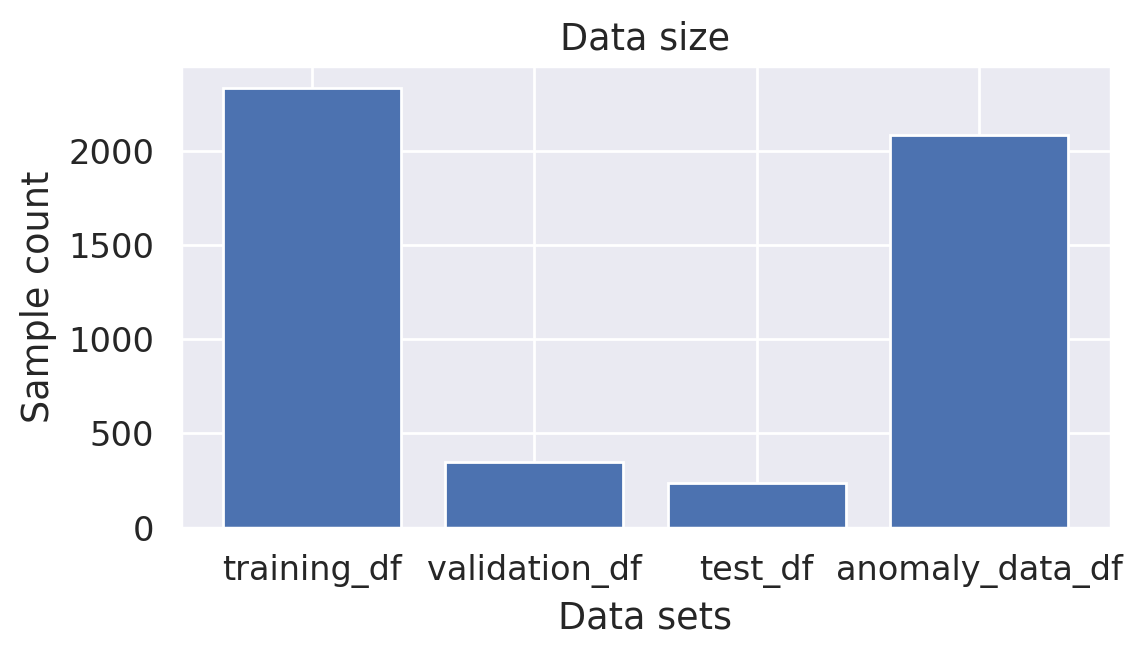

In [35]:
# data size
plt.figure(figsize=(6,3))
plt.bar(['training_df', 'validation_df', 'test_df', 'anomaly_data_df'],
        [len(training_df), len(validation_df), len(test_df), len(anomaly_data_df)])

plt.xlabel('Data sets')
plt.ylabel('Sample count')
plt.title('Data size')

print(f'Data size:\ntest_df = {len(test_df)}\nanomaly_data_df = {len(anomaly_data_df)}')
plt.show()

- **Sample count:**
  - `test_df`: 234 (negative samples)
  - `anomaly_data_df`: 2081 (positive samples)
- The classes are unbalanced, making accuracy an unsuitable metric for assessing model performance.
- **Approaches:**
    - **Under/Over Sampling:**
      - Both undersampling the majority class and oversampling the minority class are potential approaches.
      - However, oversampling the negative samples leads to a significant increase in repetitions.
      - Undersampling the positive class results in an overall reduction in the number of samples.
    - Thus, metrics like F1 Score, which are unaffected by class imbalances, are more suitable.
    - Precision and Recall Curves can be generated, and the threshold that maximizes the F1 score can be determined.

### 6.3 Metrics

In [36]:
# Compute the accuracy of the model - you need to maximize it.
from sklearn.metrics import precision_recall_curve
from tqdm import tqdm

def compute_metrics(model, dataset_normal, dataset_anomaly, device):
    """ This function computes the model KPIs
    Args:
        model (torch.nn.Module): the model
        dataset_normal (torch.tensor): data set with normal samples
        dataset_anomaly (torch.tensor): data set with anomaly samples
        device (string): device to use - cpu/cuda:0

    Returns:
        df_samples (pandas.DataFrame): dataframe with actual label, prediction, loss and features
    """
    criterion = nn.L1Loss(reduction='sum').to(device)
    # loss list for normal (n) and anomaly (a) samples
    loss_n, loss_a = [],[]

    for sequence in tqdm(dataset_normal, desc='Normal samples'):
        sequence_true = sequence.to(device)
        sequence_pred = model(sequence_true)
        loss = criterion(sequence_pred, sequence_true)
        loss_n.append( sequence.squeeze(1).tolist() + [loss.to('cpu').item()] )

    for sequence in tqdm(dataset_anomaly, desc='Anomaly samples'):
        sequence_true = sequence.to(device)
        sequence_pred = model(sequence_true)
        loss = criterion(sequence_pred, sequence_true)
        loss_a.append( sequence.squeeze(1).tolist() + [loss.to('cpu').item()] )

    # dataframe of samples with true_label and score (loss)
    normal_samples = np.concatenate( ([[0]]*len(loss_n), np.array(loss_n)), axis=1)
    anomaly_samples = np.concatenate( ([[1]]*len(loss_a), np.array(loss_a)), axis=1)
    full_samples = np.concatenate( (normal_samples, anomaly_samples) )
    df_samples = pd.DataFrame(full_samples).rename(columns={0:'label', 141:'loss'})

    # # precision and recall
    precision, recall, thresholds = precision_recall_curve(df_samples['label'], df_samples['loss'])

    # computing the F1 score for each threshold value
    pr, p_r = (precision * recall), (precision + recall)
    f1_scores = [2*(pr/p_r) if p_r > 0 else 0 for pr, p_r in zip(pr, p_r)]

    # find the index of the maximum F1-score
    best_threshold_index = np.argmax(f1_scores)

    # get the best threshold, Precision, Recall values
    best_threshold = thresholds[best_threshold_index]
    best_precision, best_recall = precision[best_threshold_index], recall[best_threshold_index]

    best_metrics = {'Best F1 Score':np.max(f1_scores),
                    'Best threshold':best_threshold,
                    'Best precision':best_precision,
                    'Best recall':best_recall}

    # dataframe update
    df_samples['pred'] = np.nan
    pred_normal_idx = df_samples[df_samples.loss < best_threshold].index
    pred_anomaly_idx = df_samples[df_samples.loss >= best_threshold].index
    df_samples.loc[pred_normal_idx, 'pred'] = 0
    df_samples.loc[pred_anomaly_idx, 'pred'] = 1

    # plot the PR curve
    plt.figure(figsize=(4,3))
    plt.plot(recall, precision, color= 'blue', label='PR curve')
    plt.scatter(best_recall, best_precision, color='tab:red', label='Best PR - Max F1 Score')

    # setting the plot parms
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.title('Precision-Recall Curve')

    plt.show()

    return df_samples

Anomaly samples: 100%|██████████| 2081/2081 [00:09<00:00, 212.04it/s]


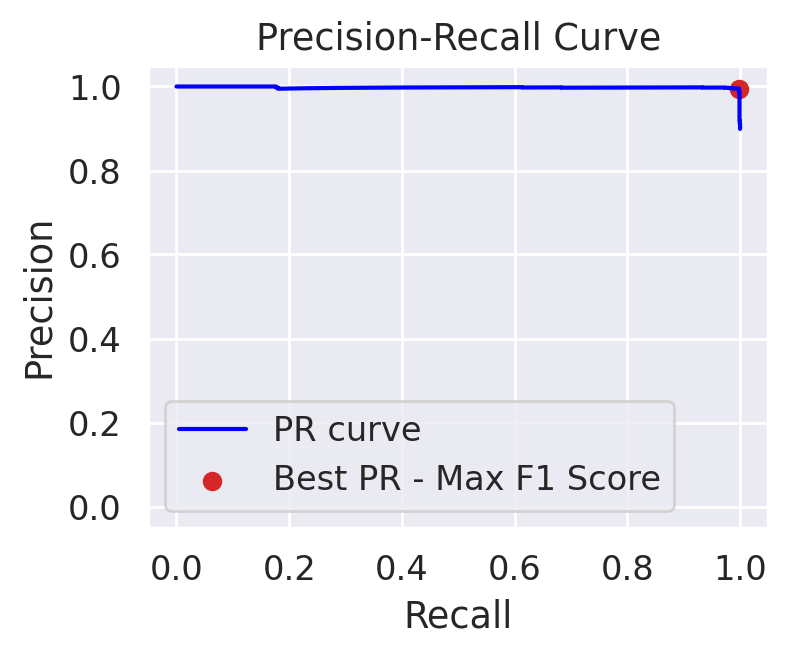

In [37]:
df_samples = compute_metrics(model = model,
                            dataset_normal = dataset_test,
                            dataset_anomaly = dataset_anomaly,
                            device = device)

In [38]:
best_model = model

In [39]:
criterion = nn.L1Loss(reduction='sum').to(device)
sample = dataset_test[1].to(device)  # dataset_anomaly[0]
criterion(best_model(sample), sample)

tensor(0.9336, device='cuda:0', grad_fn=<SumBackward0>)

### 6.5 Visualization

In [40]:
df_samples.iloc[0]

label    0.000000
1       -0.078849
2       -0.262797
3       -0.354818
4       -0.352720
           ...   
138      0.115455
139      0.142995
140      0.030996
loss     0.649942
pred     0.000000
Name: 0, Length: 143, dtype: float64

In [41]:
# sampling with fixed seed - normal/anomaly samples
features = np.arange(1, 141)
normal_samples = df_samples[df_samples.label==0].sample(8, random_state=42).astype(np.float32)
normal_samples = torch.tensor(normal_samples[features].values).unsqueeze(2)

anomaly_samples = df_samples[df_samples.label==1].sample(8, random_state=42).astype(np.float32)
anomaly_samples = torch.tensor(anomaly_samples[features].values).unsqueeze(2)

In [42]:
# func for plotting samples
def plot_samples(samples, model, title, device='cpu'):
    """ Function that plots the actual samples and the corresponding reconstructions
    Args:
        samples (torch.tensor): samples to plot
        model (torch.nn.Module): model
        title (string): suptitle of the plot
        device (string): device to use - cpu/cuda:0
    """
    samples_pred = []
    criterion = nn.L1Loss(reduction='sum').to(device)
    loss_pred = []

    for i in samples:
        pred = model(i)
        samples_pred.append(pred)
        loss_pred.append(criterion(pred,i))

    samples_pred = torch.stack(samples_pred).squeeze(2).tolist()
    samples_truth = samples.squeeze(2).tolist()

    fig, axs = plt.subplots(2, 4, figsize=(14,4.5))
    for ax, p, t, l in zip(axs.flatten(), samples_pred, samples_truth, loss_pred):
        ax.plot(np.arange(0, len(t)), t, color='tab:green', label='Truth')
        ax.plot(np.arange(0, len(p)), p, color='tab:orange', label='Prediction')
        ax.set_title(f'Loss: {round(l.item(), 3)}')
        ax.set_xlabel('Timesteps')
        ax.set_ylabel('Voltage (amplitudes)')
        ax.legend()

    plt.suptitle(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

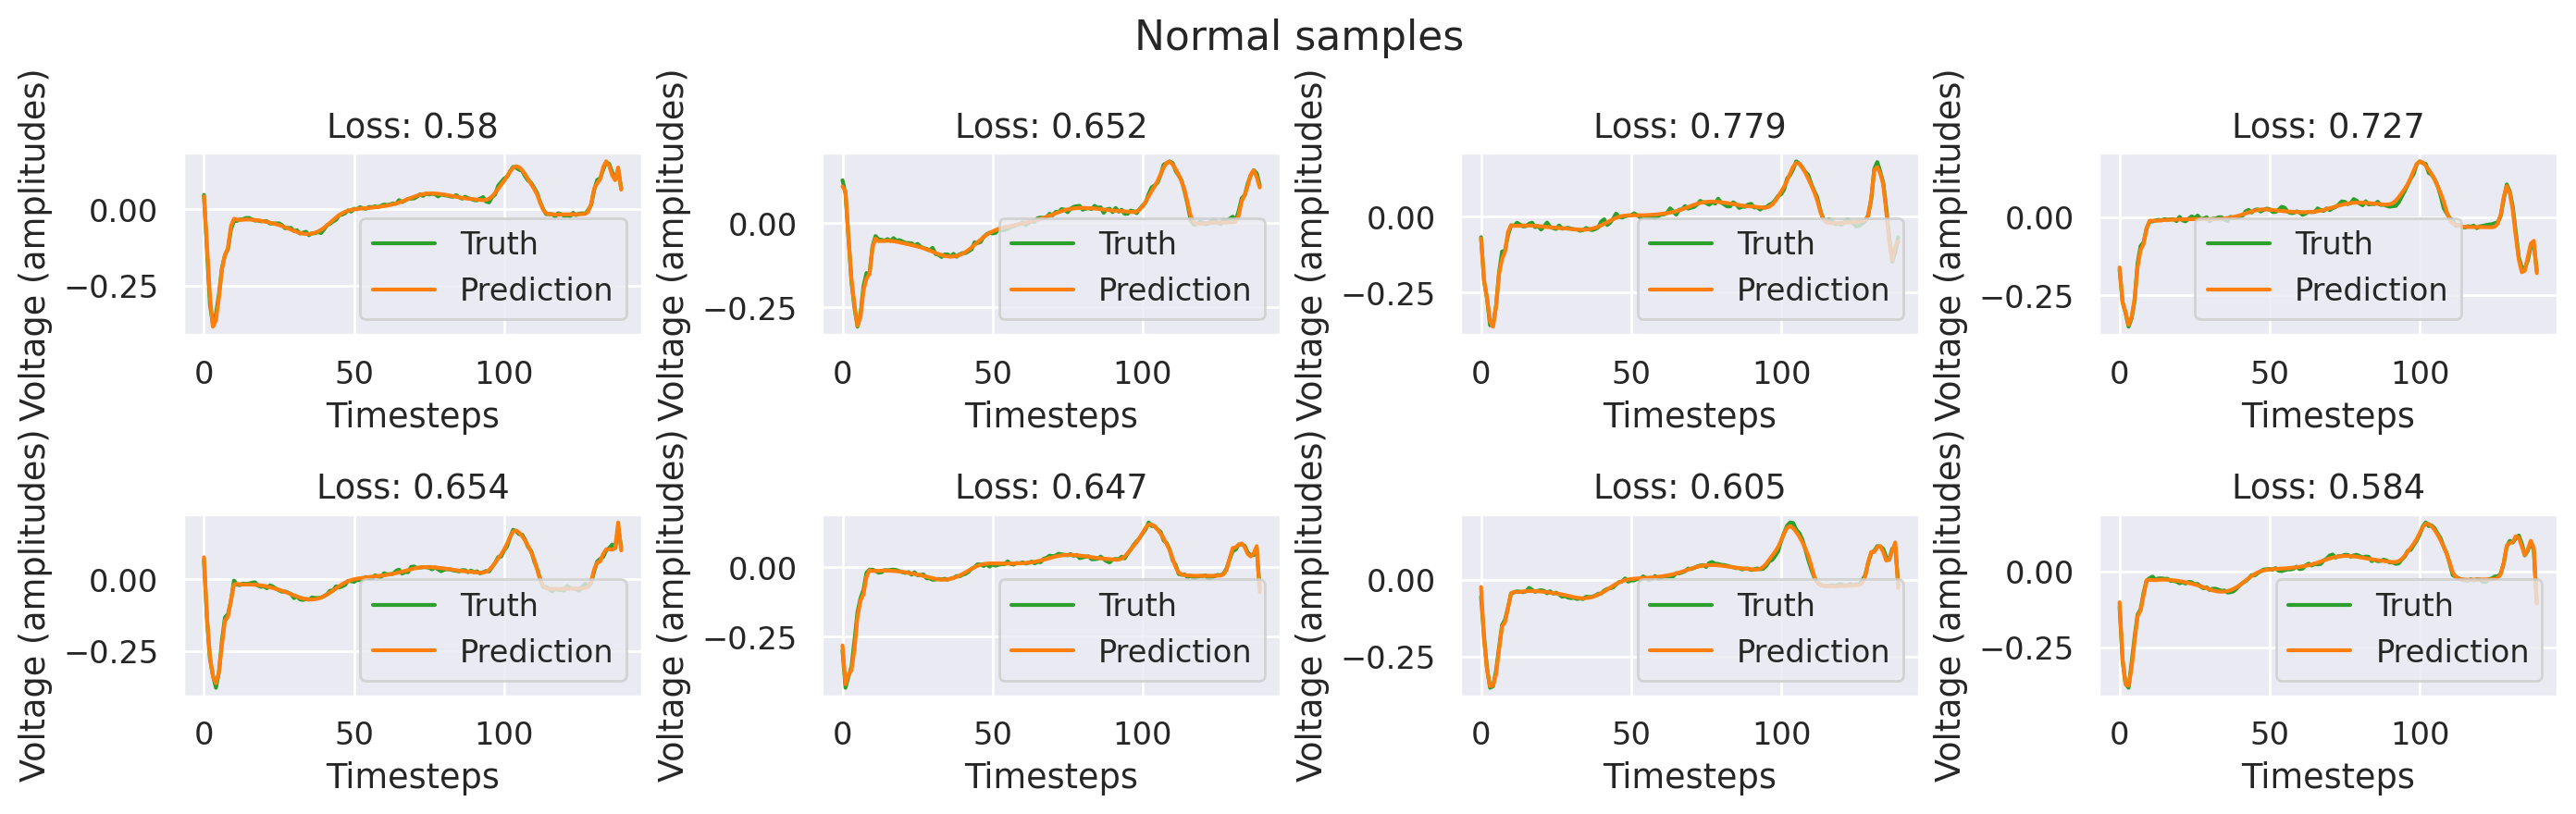

In [43]:
# Normal Samples
plot_samples(normal_samples.to(device), model, title='Normal samples')

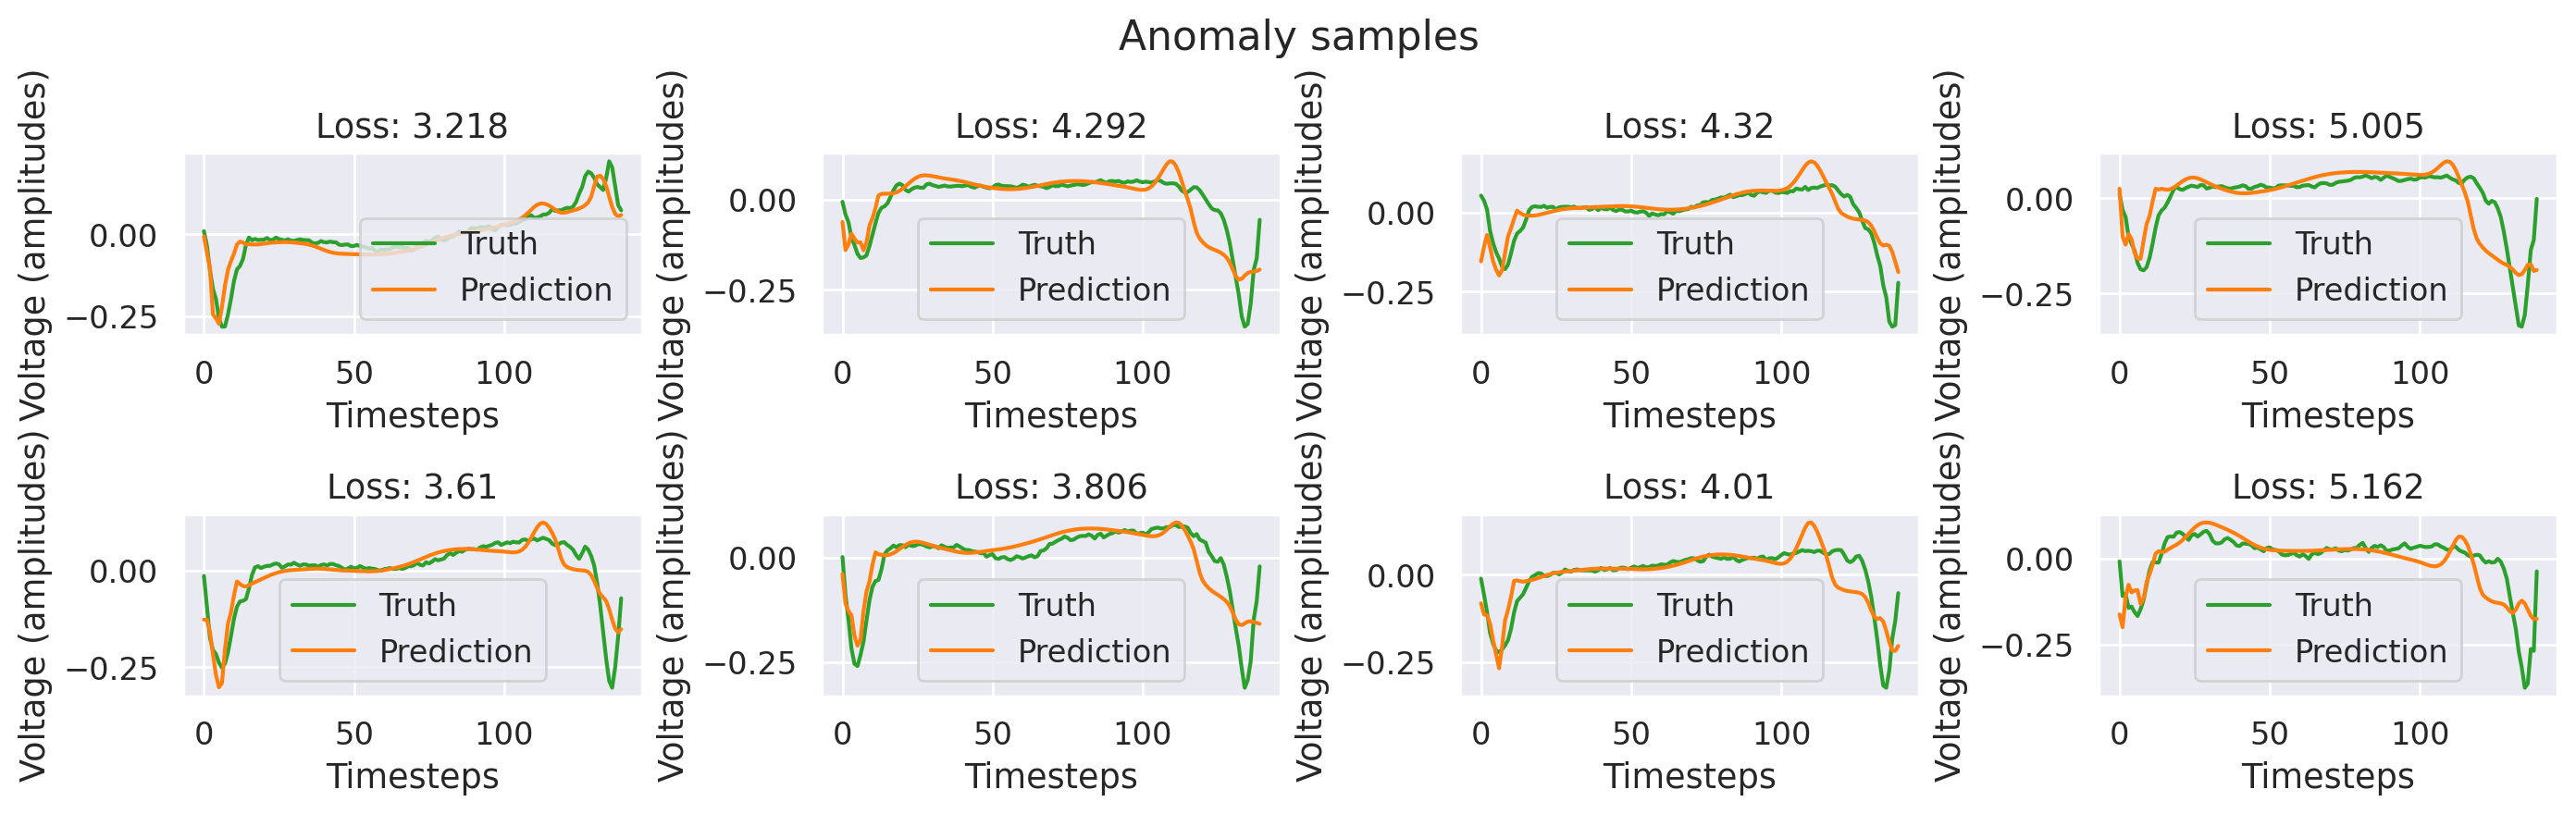

In [44]:
# Anomaly Samples
plot_samples(anomaly_samples.to(device), model, title='Anomaly samples')

The lower reconstruction error observed for normal samples, contrasted with the higher reconstruction error for anomaly samples, suggests that the autoencoder model effectively discriminates between the two classes.